# Rotation Measures and Large-Scale Structure


NOTE: The code below is work in progress for students and colleagues working with Shea Brown at the University of Iowa. The code and data are free to use, but we do ask that you contact us at shea-brown@uiowa.edu if you plan on using this in a publication. 

This is code for loading and plotting Rotation-Measures (RMs) from Hammond et al. (2013) on an all-sky Healpix map of large-scale structure. We will use two example maps, the first being the WISE-SuperCOSMOS photometric catalog and the Cosmic-Flows3 catalog. First we will import the necessary libraries 

In [1]:
%matplotlib inline
import healpy as hp
import numpy as np
#import matplotlib.pyplot as plt
import pylab as plt
from astropy.io import fits
from matplotlib import cm



## Rotation Measures
We must then import the RM catalog of Hammond et al. (2013), which comes as a FITS table. It can be found here http://www.sifa.org.au/Main/RMCatalogue 

In [2]:
hdulist = fits.open('rm_redshift_catalog.fits')
data=hdulist[1].data
l=data['GLON']
b=data['GLAT']
rm=data['NVSS_RM']
drm=data['NVSS_RM_ERR']

## Large Scale Structure from WISE-SuperCosmos
Now we will load in a Healpix image of the entire WISE-SuperCOSMOS catalog, along with a galactic mask. These come from Bilicki et al. (2016), and can be found here https://github.com/sheabrown/WHIM_Filament, where we used the data to detect filaments in front of the blazaer 1ES 1553+113. 

In [3]:
mask=hp.read_map('WISExSCOSmask.fits')
map=hp.read_map('wise_all.fits')

NSIDE = 256
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
NSIDE = 256
ORDERING = RING in fits file
INDXSCHM = IMPLICIT


## Plotting
Now we can plot the LSS map using the mollview() function within healpy, and then overplot the locations of the RMs from the catalog. In order to see the LSS a little easier, we convolve the map with a 2 degree gaussian kernal. At this point we don't care about the sign of the RMs, so we'll just represent the absolute value by the size of the circle. We also adjust the color map before plotting. 

Sigma is 50.955555 arcmin (0.014822 rad) 
-> fwhm is 119.991161 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


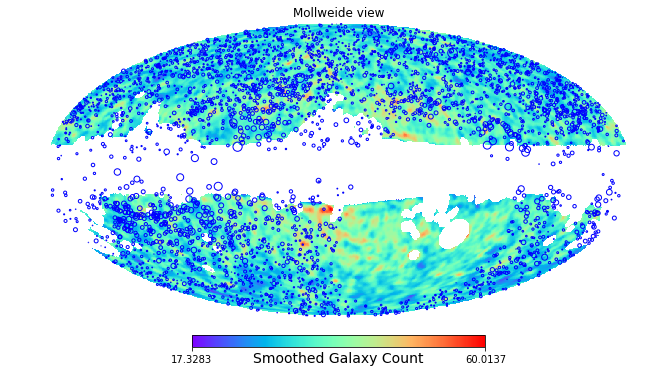

In [4]:
cool_map = cm.rainbow
cool_map.set_under("w")
smo=hp.smoothing(map,fwhm=2.0/57.3)
smo=hp.ma(smo)
smo.mask=np.logical_not(mask)
hp.mollview(smo,unit='Smoothed Galaxy Count', cmap=cool_map)

for i in range(len(rm)):
        hp.projscatter(l[i],b[i],lonlat=True,s=np.abs(rm[i])/5.,coord='G',linewidth=1,color='blue',facecolors='none')
        
plt.plot()
plt.show()

## Large-Scale Structure from CosmicFlows3
Let us try it out on the Cosmic-Flows3 data.

NSIDE = 256
ORDERING = RING in fits file
INDXSCHM = IMPLICIT
Sigma is 50.955555 arcmin (0.014822 rad) 
-> fwhm is 119.991161 arcmin
Sigma is 0.000000 arcmin (0.000000 rad) 
-> fwhm is 0.000000 arcmin


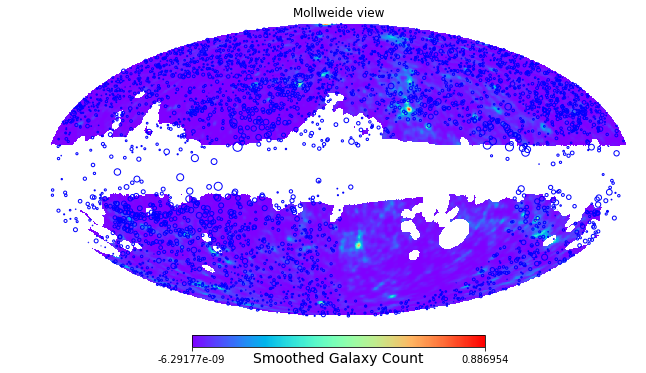

In [5]:
map=hp.read_map('cosmicflows3.fits')
smo=hp.smoothing(map,fwhm=2.0/57.3)
smo=hp.ma(smo)
smo.mask=np.logical_not(mask)
hp.mollview(smo,unit='Smoothed Galaxy Count', cmap=cool_map)

for i in range(len(rm)):
        hp.projscatter(l[i],b[i],lonlat=True,s=np.abs(rm[i])/5.,coord='G',linewidth=1,color='blue',facecolors='none')
        
plt.plot()
plt.show()